### Problem Statement:

##### How good is player X against Chennai super kings in Chepauk Stadium when they are playing with 3 spinners?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('max_colwidth',-1)

In [2]:
deliveries = pd.read_csv('deliveries.csv')

In [3]:
matches = pd.read_csv('matches.csv')

In [4]:
df = deliveries.copy()

In [5]:
mdf = matches.copy()

In [6]:
def getphase(over):
    if over < 6:
        return "Powerplay"
    elif over < 15:
        return "Middle"
    else:
        return "Death"

In [7]:
def BallsPerBoundary(Balls,Boundaries):
    if Boundaries > 1:
        return Balls/Boundaries
    else:
        return Balls

In [8]:
def BallsPerDismissal(Balls,Dismissals):
    if Dismissals > 1:
        return Balls/Dismissals
    else:
        return Balls

In [9]:
def Average(Runs,Dismissals):
    if Dismissals > 1:
        return Runs/Dismissals
    else:
        return Runs

In [10]:
def StrikeRotation(CountofRuns,Balls):
    return  (CountofRuns / Balls)*100

In [11]:
def DotPercentage(Dots,Balls):
    return (Dots/Balls)*100

In [12]:
df['Phase'] = df['over'].apply(lambda x : getphase(x))

In [13]:
comb = pd.merge(df,mdf,on='matchId',how='left')

PARAMETERS TO BE CONSIDERED : RPI | BPB | BPD | STRIKERATE | AVERAGE | STRIKEROTATION % | DOT % |  

In [14]:
def byCustom(df,current_venue,current_phase,current_opposition):
    df = df[df.venue == current_venue]
    df = df[df.Phase == current_phase]
    df = df[df.bowling_team == current_opposition]

    
    df['isdot'] = df['batsman_runs'].apply(lambda x : 1 if x == 0 else 0)
    df['isone'] = df['batsman_runs'].apply(lambda x : 1 if x == 1 else 0)
    df['istwo'] = df['batsman_runs'].apply(lambda x : 1 if x == 2 else 0)
    df['isthree'] = df['batsman_runs'].apply(lambda x : 1 if x == 3 else 0)
    df['isfour'] = df['batsman_runs'].apply(lambda x : 1 if x == 4 else 0)
    df['issix'] = df['batsman_runs'].apply(lambda x : 1 if x == 6 else 0)

    runs = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns = {'batsman_runs' : 'Runs'}))
    balls = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].count().reset_index().rename(columns = {'batsman_runs' : 'Balls'}))
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x : len(list(np.unique(x)))).reset_index().rename(columns={'matchId':'Innings'}))
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count().reset_index().rename(columns = {'player_dismissed' : 'Dismissals'}))
    sixes = pd.DataFrame(df.groupby(['batsman'])['issix'].sum().reset_index().rename(columns = {'issix' : 'Sixes'}))
    fours = pd.DataFrame(df.groupby(['batsman'])['isfour'].sum().reset_index().rename(columns = {'isfour' : 'Fours'}))
    dots = pd.DataFrame(df.groupby(['batsman'])['isdot'].sum().reset_index().rename(columns = {'isdot' : 'Dots'}))
    ones = pd.DataFrame(df.groupby(['batsman'])['isone'].sum().reset_index().rename(columns = {'isone' : 'Ones'}))
    twos = pd.DataFrame(df.groupby(['batsman'])['istwo'].sum().reset_index().rename(columns = {'istwo' : 'Twos'}))
    threes = pd.DataFrame(df.groupby(['batsman'])['isthree'].sum().reset_index().rename(columns = {'isthree' : 'Threes'}))

    df = pd.merge(runs,balls,on='batsman').merge(innings,on='batsman').merge(dismissals,on='batsman').merge(fours,on='batsman').merge(sixes,on='batsman').merge(ones,on='batsman').merge(twos,on='batsman').merge(threes,on='batsman').merge(dots,on='batsman')
    
    return df 


In [15]:
df1 = byCustom(comb,'MA Chidambaram Stadium, Chepauk','Middle','Chennai Super Kings')

In [16]:
df1 = df1[(df1.Balls>20) & (df1.Innings>2)]

In [17]:
df1['RPI'] = df1.apply(lambda x : x['Runs'] / x['Innings'],axis=1)
df1['BPB'] = df1.apply(lambda x : BallsPerBoundary(x['Balls'],(x['Fours']+x['Sixes'])),axis=1)
df1['BPD'] = df1.apply(lambda x : BallsPerDismissal(x['Balls'],x['Dismissals']),axis=1)
df1['StrikeRate'] = df1.apply(lambda x : x['Runs'] / x['Balls'] * 100 , axis =1 ) 
df1['Average'] = df1.apply ( lambda x : Average(x['Runs'],x['Dismissals']),axis=1)
df1['StrikeRotation%'] = df1.apply(lambda x :StrikeRotation((x['Ones']+x['Twos']+x['Threes']) , x['Balls']),axis=1)
df1['Dot%'] =df1.apply(lambda x : DotPercentage(x['Dots'],x['Balls']),axis=1)

In [18]:
df1.sort_values(by='Runs',ascending=False).reset_index(drop=True).head()

,batsman,Runs,Balls,Innings,Dismissals,Fours,Sixes,Ones,Twos,Threes,Dots,RPI,BPB,BPD,StrikeRate,Average,StrikeRotation%,Dot%
0,V Kohli,175,150,7,4,11,5,67,17,0,50,25.000000,9.375000,37.500000,116.666667,43.750000,56.000000,33.333333
1,JH Kallis,124,124,5,3,10,1,70,4,0,39,24.800000,11.272727,41.333333,100.000000,41.333333,59.677419,31.451613
2,SR Watson,121,70,4,2,9,7,33,5,0,16,30.250000,4.375000,35.000000,172.857143,60.500000,54.285714,22.857143
3,DA Warner,104,96,4,3,2,4,44,14,0,32,26.000000,16.000000,32.000000,108.333333,34.666667,60.416667,33.333333
4,SE Marsh,104,54,3,1,8,7,28,1,0,10,34.666667,3.600000,54.000000,192.592593,104.000000,53.703704,18.518519


### Determining the pair wise values by Saaty Values:

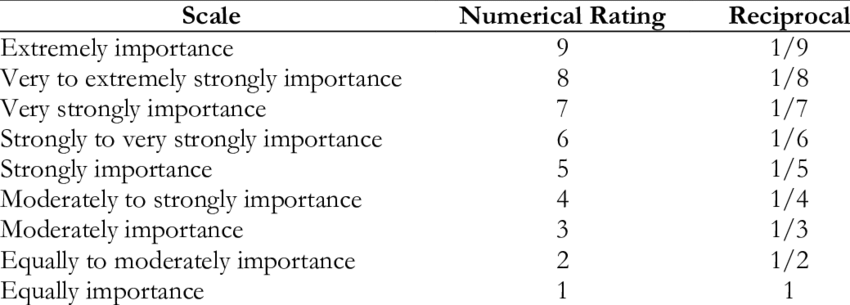

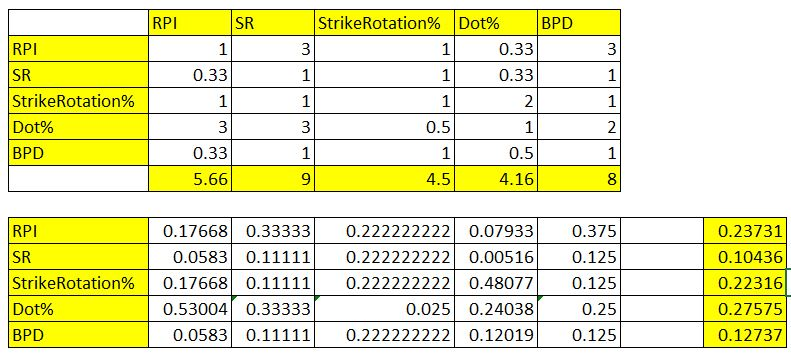


In [19]:
wt_RPI,wt_SR,wt_SRP,wt_DP,wt_BPD = 0.24,0.10,0.22,0.28,0.13

In [20]:
df1['calc_RPI'] = df1['RPI'].apply(lambda x : x*x)
df1['calc_SR'] = df1['StrikeRate'].apply(lambda x : x*x)
df1['calc_SRP'] = df1['StrikeRotation%'].apply(lambda x : x*x)
df1['calc_DP'] = df1['Dot%'].apply(lambda x : x*x)
df1['calc_BPD'] = df1['BPD'].apply(lambda x : x*x)

sq_RPI,sq_SR,sq_SRP ,sq_DP ,sq_BPD = np.sqrt(df1[['calc_RPI','calc_SR','calc_SRP','calc_DP','calc_BPD']].sum(axis=0))

df1['calc_RPI'] = df1['calc_RPI'].apply(lambda x : x/sq_RPI)
df1['calc_SR'] = df1['calc_SR'].apply(lambda x : x/sq_SR)
df1['calc_SRP'] = df1['calc_SRP'].apply(lambda x : x/sq_SRP)
df1['calc_DP'] = df1['calc_DP'].apply(lambda x : x/sq_DP)
df1['calc_BPD'] = df1['calc_BPD'].apply(lambda x : x/sq_BPD)

df1['calc_RPI'] = df1['calc_RPI'].apply(lambda x : x*wt_RPI)
df1['calc_SR'] = df1['calc_SR'].apply(lambda x : x*wt_SR)
df1['calc_SRP'] = df1['calc_SRP'].apply(lambda x : x*wt_SRP)
df1['calc_DP'] = df1['calc_DP'].apply(lambda x : x*wt_DP)
df1['calc_BPD'] = df1['calc_BPD'].apply(lambda x : x*wt_BPD)

best_RPI,worst_RPI = max(df1['calc_RPI']),min(df1['calc_RPI'])
best_SR,worst_SR = max(df1['calc_SR']),min(df1['calc_SR'])
best_SRP,worst_SRP = max(df1['calc_SRP']),min(df1['calc_SRP'])
best_DP,worst_DP = min(df1['calc_DP']),max(df1['calc_DP'])
best_BPD,worst_BPD = max(df1['calc_BPD']),min(df1['calc_BPD'])


#### CALCULATION - COMPARISION AGAINST BEST AND WORST VALUES:

In [21]:
df1['dev_best_RPI'] = df1['calc_RPI'].apply(lambda x : (x-best_RPI)*(x-best_RPI))
df1['dev_best_SR'] = df1['calc_SR'].apply(lambda x : (x-best_SR)*(x-best_SR))
df1['dev_best_SRP'] = df1['calc_SRP'].apply(lambda x : (x-best_SRP)*(x-best_SRP))
df1['dev_best_DP'] = df1['calc_DP'].apply(lambda x : (x-best_DP)*(x-best_DP))
df1['dev_best_BPD'] = df1['calc_BPD'].apply(lambda x : (x-best_BPD)*(x-best_BPD))

df1['dev_best_sqrt'] = df1.apply(lambda x : x['dev_best_RPI'] + x['dev_best_SR']+x['dev_best_SRP']+x['dev_best_DP']+x['dev_best_BPD'],axis=1)

df1['dev_worst_RPI'] = df1['calc_RPI'].apply(lambda x : (x-worst_RPI)*(x-worst_RPI))
df1['dev_worst_SR'] = df1['calc_SR'].apply(lambda x : (x-worst_SR)*(x-worst_SR))
df1['dev_worst_SRP'] = df1['calc_SRP'].apply(lambda x : (x-worst_SRP)*(x-worst_SRP))
df1['dev_worst_DP'] = df1['calc_DP'].apply(lambda x : (x-worst_DP)*(x-worst_DP))
df1['dev_worst_BPD'] = df1['calc_BPD'].apply(lambda x : (x-worst_BPD)*(x-worst_BPD))

df1['dev_worst_sqrt'] = df1.apply(lambda x : x['dev_worst_RPI'] + x['dev_worst_SR']+x['dev_worst_SRP']+x['dev_worst_DP']+x['dev_worst_BPD'],axis=1)

df1['score'] = df1.apply(lambda x : x['dev_worst_sqrt'] / (x['dev_worst_sqrt'] + x['dev_best_sqrt']),axis=1)

In [47]:
df1.to_csv('df.csv')

In [41]:
df1[['batsman','Runs','Balls','Innings','Dismissals','score','RPI','BPB','BPD','StrikeRate','Average','StrikeRotation%','Dot%']].sort_values(by='score',ascending=False).reset_index(drop=True).head(15)

,batsman,Runs,Balls,Innings,Dismissals,score,RPI,BPB,BPD,StrikeRate,Average,StrikeRotation%,Dot%
0,SE Marsh,104,54,3,1,0.902974,34.666667,3.600000,54.000000,192.592593,104.000000,53.703704,18.518519
1,SR Watson,121,70,4,2,0.727575,30.250000,4.375000,35.000000,172.857143,60.500000,54.285714,22.857143
2,G Gambhir,86,73,3,1,0.659184,28.666667,12.166667,73.000000,117.808219,86.000000,63.013699,28.767123
3,NV Ojha,64,41,3,2,0.478326,21.333333,5.857143,20.500000,156.097561,32.000000,53.658537,29.268293
4,Y Venugopal Rao,67,51,3,1,0.459542,22.333333,7.285714,51.000000,131.372549,67.000000,54.901961,31.372549
5,MS Bisla,89,66,3,2,0.456356,29.666667,6.600000,33.000000,134.848485,44.500000,54.545455,30.303030
6,MK Pandey,39,30,3,2,0.388730,13.000000,7.500000,15.000000,130.000000,19.500000,63.333333,23.333333
7,DA Miller,38,32,3,1,0.381488,12.666667,10.666667,32.000000,118.750000,38.000000,65.625000,25.000000
8,AB de Villiers,92,68,5,2,0.360269,18.400000,6.181818,34.000000,135.294118,46.000000,52.941176,30.882353
9,V Kohli,175,150,7,4,0.322300,25.000000,9.375000,37.500000,116.666667,43.750000,56.000000,33.333333


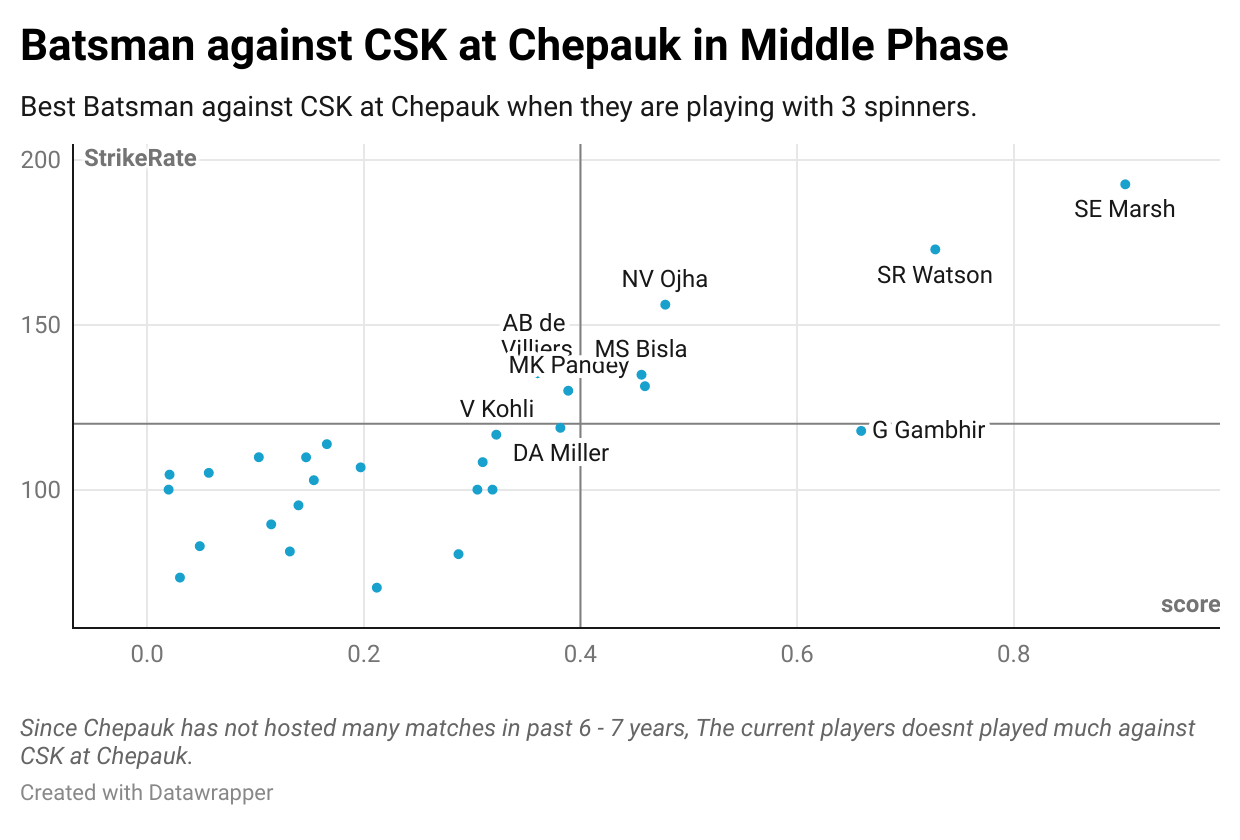

### Conclusion

According to our Analysis, when overall seasons are taken into consideration, Shaun Marsh is the best player in that phase against Chennai in Chepauk. 

Since there is not much games that CSK played in Chepauk for the past 6 or 7 years, the amount of balls that current generation players played here is considerably low. 

With the available Data, it is evident that Manish Pandey is the best player against CSK in chepauk during the overs of 7 to 15 having strike rate of 130 and strikerotation rate of 63% and dot ball percentage of just 23%

Next three players in this list are David Miller , Virat Kohli and David Warner respectively.